# AWSOM: Arbitrary Window Stream mOdeling Method

Papadimitriou, Spiros, Anthony Brockwell, and Christos Faloutsos.  
[Adaptive, hands-off stream mining.](https://apps.dtic.mil/sti/pdfs/ADA461108.pdf)  
In Proceedings 2003 VLDB Conference. Morgan Kaufmann, 2003.  

- Major properties:  
    - No human in the loop  
    - Periodic component identification  
    - Online, one-path algorithm  
    - Limited memory  
    - Simple, but powerful patterns  
    - Any-time forecasting/outlier detection  
- Keywords:
    - Discrete Wavelet Transform (DWT)
    - Autoregression (AR)
    - Recursive least square (RLS)

In [9]:
import warnings
warnings.filterwarnings("ignore")
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, style="whitegrid", palette="muted")
import tqdm
import pprint
pp = pprint.PrettyPrinter(indent=4)
import pywt

## Data preparation

In [10]:
def generate_triangles(length=40000, period=256, amplitude=10):
    assert period % 4 == 0
    amp = amplitude / 2
    period = int(period / 4)

    line = np.linspace(0, amp, period)
    wave = np.concatenate([line, -1 * line + amp, -1 * line, line - amp])
    n_wave = np.ceil(length / period / 4).astype(int)

    return np.tile(wave, (n_wave,))

In [11]:
def generate_mix(length=40000, period=256, amplitude=50):

    amp = amplitude / 2
    period = int(period / 2)

    square = np.concatenate([np.full(period, amp), np.full(period, -amp)])
    n_square = np.ceil(length / period / 2).astype(int)
    squares = np.tile(square, (n_square,))
    
    sine = .25 * amplitude * np.sin(np.linspace(0, 2 * np.pi, int(period / 2)))
    n_sine = np.ceil(len(squares) / len(sine)).astype(int)
    sines = np.tile(sine, (n_sine,))

    return squares + sines

In [12]:
def generate_impulses(length=40000, period=256, peak=200):

    impulses = np.zeros(int(length))
    impulses[np.arange(0, int(length), period)] = peak

    return impulses

In [21]:
def plot_timeseries(data, title="", figsize=(8, 3), max_len=10000):

    fig, ax = plt.subplots(figsize=figsize)
    max_len = min(len(data), max_len)
    
    ax.plot(data[:max_len])
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.tick_params(axis="both")
    fig.tight_layout()
    
    return fig, ax

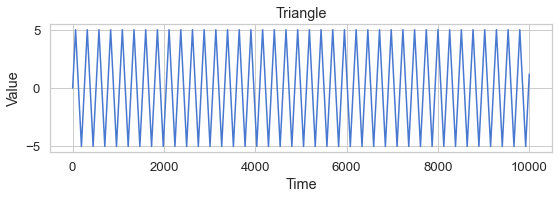

In [22]:
K = 1024
triangle = generate_triangles(length=40*K)
plot_timeseries(triangle, title="Triangle")
plt.show()

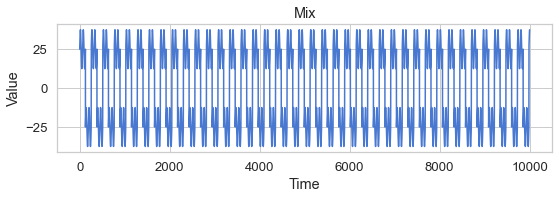

In [23]:
K = 1024
mix = generate_mix(length=40*K)
plot_timeseries(mix, title="Mix")
plt.show()

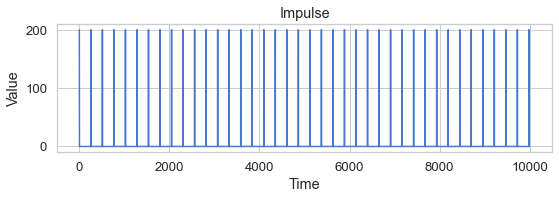

In [170]:
K = 1024
impulse = generate_impulses(length=128*K)
plot_timeseries(impulse, title="Impulse")
plt.show()

## Study on DWT

- Introduction
    - blank
- Mother wavelet browser
    - Haar: http://wavelets.pybytes.com/wavelet/haar/
    - DB6: http://wavelets.pybytes.com/wavelet/db6/
- PyWavelet documentation
    - https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
    - https://github.com/PyWavelets/pywt/blob/master/pywt/_multilevel.py

In [33]:
def plot_coefs(W, V, figsize=(8, 3)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    ax[0].stem(W)
    ax[0].set_title("Scaling coefficients: W")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Value")

    ax[1].stem(V)
    ax[1].set_title("Detail coefficients: V")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Value")
    
    fig.tight_layout()
    return fig, ax

In [34]:
data = triangle
# data = mix
# data = impulse

wavelet = "haar"  # ハール
# wavelet = "db6"  # Daubenchies-6

level = 3

# wavedec calls 'dwt' function inside.
coefs = pywt.wavedec(data, wavelet, level=level)

# the first element is approximation coefficients (W in the paper),
# and the following elements are the details coefficients (V in the paper)
for i, c in enumerate(coefs):
    if i == 0:
        print(f"cA{level}:", c.shape)
    else:
        print(f"cD{level - i + 1}:", c.shape)

cA3: (5120,)
cD3: (5120,)
cD2: (10240,)
cD1: (20480,)


In [35]:
# coef_arr, coef_slices = pywt.coeffs_to_array(coefs)

Note: pywt.wavedec is equivalent to repeating pywt.dwt
- The smooth component, W:
    - low-frequency component
- The detail component, V:
    - high-frequency component

Level= 1


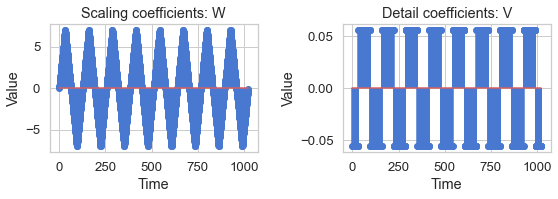

Level= 2


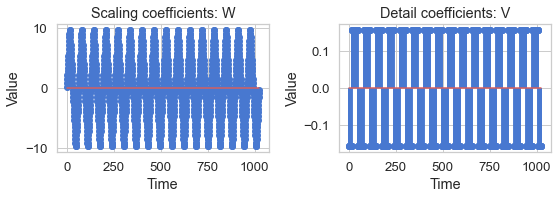

Level= 2


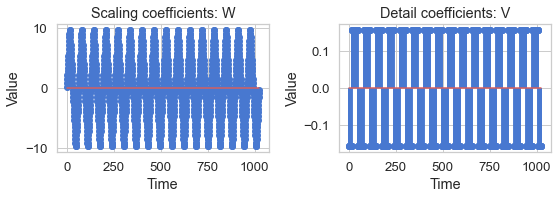

In [36]:
# 1st level
W0, V0 = pywt.dwt(data, wavelet)
print("Level= 1")
plot_coefs(W0[:1*K], V0[:1*K])
plt.show()

# 2nd level
W1, V1 = pywt.dwt(W0, wavelet)
print("Level= 2")
plot_coefs(W1[:1*K], V1[:1*K])
plt.show()

# 3rd level
W2, V2 = pywt.dwt(W1, wavelet)
print("Level= 2")
plot_coefs(W1[:1*K], V1[:1*K])
plt.show()

### Reconstruction

- PyWavelet documentation:  
https://pywavelets.readthedocs.io/en/latest/ref/idwt-inverse-discrete-wavelet-transform.html

In [37]:
# Decomposition
coefs = pywt.wavedec(data, 'haar', level=2)
coefs[0][:20]
for V in coefs[1:]:
    V[:] = 0

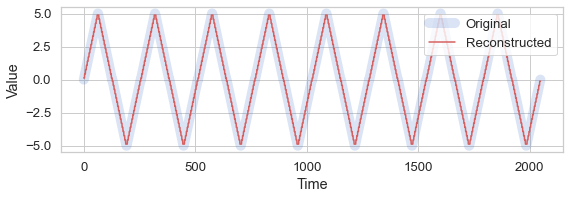

In [41]:
# Reconstruction
rec_ = pywt.waverec(coefs, 'haar')

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(data[:2*K], label="Original", lw=10, alpha=0.2, c="b")
ax.plot(rec_[:2*K], label="Reconstructed", c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()

fig.tight_layout()

## Study on AutoRegression (AR)

- About autocorrelation:  
https://youtu.be/jt5nl2VEpwg
- About autoregressive order-one process:  
https://youtu.be/AN0a58F6cxA

### AR

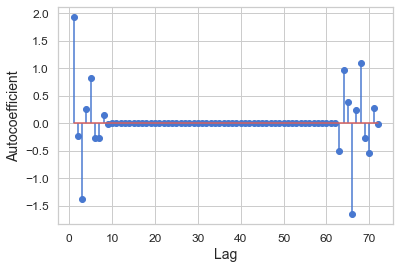

In [42]:
# Select a dataset
data = triangle

# Set the number of auto coefficients: p
# p = 10
p = 72

# Make regression samples
samples = [(data[t:t+p], data[t+p]) for t in range(len(data) - p -1)]
X, y = zip(*samples)  # unpack tuples
X, y = np.array(X), np.array(y)

# Solve mean squared error minimization
# besed on Linear algebra 
a = np.linalg.inv(X.T @ X) @ X.T @ y  # a: auto coefficients

# Plot autocoefficeints
fs = 14
plt.figure(figsize=(6, 4))
plt.stem(np.arange(1, len(a)+1), a[::-1])
plt.tick_params(axis="both", labelsize=fs-2)
plt.xlabel("Lag", fontsize=fs)
plt.ylabel("Autocoefficient", fontsize=fs)
plt.show()

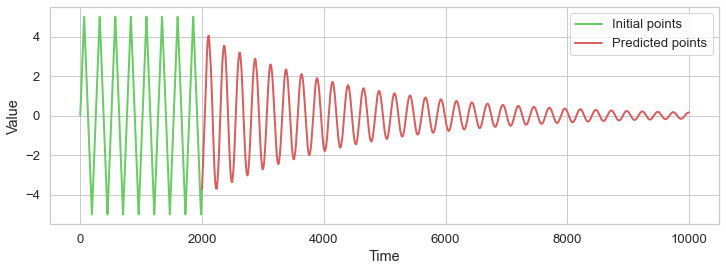

In [44]:
# Reconstruction
rec_ = np.zeros(data.shape)

# Set the initial points
n_init = 2000
rec_[:n_init] = data[:n_init]  

# Predict future values recursively
for t in range(n_init, len(data) - p):
        rec_[t] = np.dot(a, rec_[t-p:t])

max_len = min(10000, len(data))

plt.figure(figsize=(12, 4))
plt.plot(np.arange(n_init), rec_[:n_init], lw=2, c="g")
plt.plot(np.arange(n_init, max_len), rec_[n_init:max_len], lw=2, c="r")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(("Initial points", "Predicted points"))
plt.show()

### Seasonal AR (SAR)

In [45]:
# Select a dataset
# data = triangle
data = mix
# data = impulse

# Set the number of  auto coefficients
p = 10

# Set the number of seasonal auto coefficients
sp = 3

# Set a period
s = 256

# Make regression samples
X = []
y = []
start_point = min(s*sp, p) + 1

for t in range(start_point, len(data) - 1):
    y.append(data[t])
    X.append(np.concatenate([
        data[[t - s * (u + 1) for u in range(sp)]],
        data[t - p:t]
    ]))

X, y = np.array(X), np.array(y)

# Solve mean squared error minimization
# besed on Linear algebra,
# but this will show you LinAlgError (i.e., FAILED)
# as mentioned in the paper
a = np.linalg.inv(X.T @ X) @ X.T @ y  # a: auto coefficients
a.shape

LinAlgError: Singular matrix

We can avoid this LinAlgError by the pseudo-inverce matrix
- Wikipedia:  
https://ja.wikipedia.org/wiki/%E6%93%AC%E4%BC%BC%E9%80%86%E8%A1%8C%E5%88%97
- Numpy document:  
https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
- Free book about the linear algebra:  
https://mml-book.github.io/book/mml-book.pdf

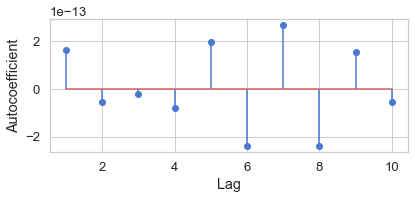

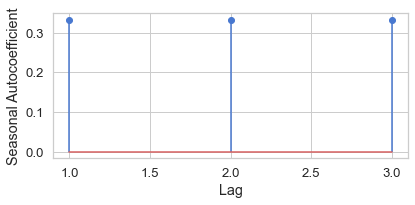

In [47]:
a = np.linalg.pinv(X.T @ X) @ X.T @ y
a.shape

# Plot results
plt.figure(figsize=(6, 3))
plt.stem(np.arange(1, p+1), a[sp:][::-1])
plt.xlabel("Lag")
plt.ylabel("Autocoefficient")
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
plt.stem(np.arange(1, sp+1), a[:sp][::-1])
plt.xlabel("Lag")
plt.ylabel("Seasonal Autocoefficient")
plt.tight_layout()
plt.show()

## AWSOM model

In [48]:
class AWSOM:
    def __init__(self, order, wavelet='haar', max_depth=10) -> None:
        assert type(order) == list
        self.order = np.array(order, dtype=int)
        self.wavelet = wavelet
        self.max_depth = max_depth
        self.lmd = len(order)  # depth of the AWSOM model
        self.n_eqn = self.max_depth - self.lmd + 1
        self.level_ids = [list(range(i, i+self.lmd)) for i in range(self.n_eqn)]
        
    def init_params(self, data):
        """ Estimate the initial AWSOM coefficients: beta_{dl, dt}
        """
        # First layer
        W0, _ = pywt.dwt(data, self.wavelet)
        W = [W0]
        
        for _ in range(self.max_depth):
            Wi, _ = pywt.dwt(W[-1], self.wavelet)
            W.append(Wi)
        
        # Keep only the last max(n_0,..., n_{lambda}) coefficients
        n_max = self.order.max()
        self.W = [Wi[-(n_max+1):] for Wi in W]
            
        n_ = self.order
        k = self.get_n_params()
        XTX = [np.zeros((k, k)) for _ in range(self.n_eqn)]
        XTy = [np.zeros((k,)) for _ in range(self.n_eqn)]

        for i in range(self.n_eqn):
            # Initialize variables for the i-th level equation
            X, y = [], []

            for t in range(n_[0], W[i].shape[0] - 1):
                X_ = []
                for j in range(self.lmd):
                    t_dt = int(t / (2 ** j))
                    X_.append(W[i + j][t_dt - n_[j]:t_dt])
                
                X_ = np.concatenate(X_)
                if X_.shape[0] == k:
                    X.append(X_)
                    y.append(W[i][t])  # response variable
            
            X, y = np.array(X), np.array(y)
            XTX[i] = X.T @ X
            XTy[i] = X.T @ y
            print(f"depth= {i}, # samples= {len(X)}")
            
        # Values kept for RLS
        self.XTX = XTX
        self.XTy = XTy
            
    def print_status(self):
        print("\n# Wavelet coefficients:")
        for i in range(self.max_depth):
            print(f"W[{i+1}]=")
            pp.pprint(self.W[i])

        print("\n# Autocoefficients:")
        for i in range(self.n_eqn):
            print(f"b[{i+1}]=")
            pp.pprint(self.get_beta(i))
        
    def get_n_params(self):
        return self.order.sum()  # k

    def get_beta(self, index):
        try:
            return np.linalg.inv(self.XTX[index]) @ self.XTy[index]
        except:
            # Avoid LinAlgError
            return np.linalg.pinv(self.XTX[index]) @ self.XTy[index]
        
    @staticmethod
    def get_minimum_batch(awsom_order):
        assert type(awsom_order) == list

        window_sizes = [2 * (level + 1) * n_coef for level, n_coef in enumerate(awsom_order)]
        min_window = min(window_sizes)
        seed = np.cumprod(np.full(20, 2))  # e.g., [2, 4, 8, 16,...]
        index = (seed < min_window).sum()
        min_batch = seed[index]
        return min_batch
    
    @staticmethod
    def _concat_coefs(W, order):
        return np.concatenate([Wi[-n-1:-1] for Wi, n in zip(W, order)]).flatten()
        
    def _update_coefs(self, level, value):
        # discard the oldest element
        self.W[level] = np.roll(self.W[level], -1)
        # insert the new element
        self.W[level][-1] = value[0]
    
    def _update_crest(self, t, new_data):
        
        updated_coef_ids = []

        for i in range(self.max_depth):
            if t % (2 ** (i + 1)) == 0:
                
                # Compute W[l, t/2^{l+1}]
                target = new_data if i == 0 else self.W[i-1][-2:]
                Wnew, _ = pywt.dwt(target, self.wavelet)                

                # Delete W[l, t/2^{l+1} - L]
                self._update_coefs(i, Wnew)
                updated_coef_ids.append(i)
                    
        return updated_coef_ids

    def update(self, t, new_data):
        """
            Xt: an observation (float)
            t: current timestamp (int)
        """
        # Step 1
        updated_ids = self._update_crest(t, new_data)

        # Step 2
        for i in range(self.n_eqn):
            if i in updated_ids:
                X = self._concat_coefs(self.W[i:i+self.lmd], self.order)
                y = self.W[i][-1]
                self.XTX[i] += np.outer(X, X)
                self.XTy[i] += np.dot(X, y)

    def model_selection(self,):
        raise NotImplementedError

    def predict(self, t, size, level=0):

        # Get AWSOM order
        n_ = self.order

        # Get the latest wavelet coefficients
        W = [copy.deepcopy(self.W[level+i][-n_[i]:]) for i in range(self.lmd)]
        
        # Get current autocoefficients
        beta = self.get_beta(level)
                
        for t in tqdm.trange(t+1, t + size):
            for i in range(self.lmd):
                if t % (2 ** (level + i + 1)) == 0:
                    if i == 0:
                        X = np.concatenate([W[i][-n_[i]:] for i in range(self.lmd)])
                        Wpred = np.dot(X, beta)
                        W[0] = np.append(W[0], Wpred)
                    else:
                        W[i] = np.append(W[i], pywt.dwt(W[i-1][-2:], self.wavelet))
        
        # Scaling coefficients
        coefs = [W[0][n_[0]:]]

        # Dummy detail coefficients
        coefs += [np.zeros(len(coefs[0]) * (2 ** (i))) for i in range(level + 1)]

        return pywt.waverec(coefs, self.wavelet)

## AWSOM simulation

### Triangle data

In [210]:
data = triangle
# data = mix
# data = impulse

# Set AWSOM order
# n = [6, 4, 2]  # i.e., n_0 = 6, n_1 - 4, n_2 = 2
# n = [10, 5]
n = [10]

# Set mother wavelet
wavelet = "haar"
# wavelet = "db6"  # not available

# Get AWSOM instance
awsom = AWSOM(n, wavelet=wavelet, max_depth=10)
print("Input:", data.shape)
print(f"AWSOM({n}) (total order k= {awsom.get_n_params()})")

Input: (40960,)
AWSOM([10]) (total order k= 10)


In [211]:
# Initialization
init_len = 20 * K
init_data = data[:init_len]

print("# Data size in initilization:", init_data.shape)
awsom.init_params(init_data)

awsom.print_status()

# Data size in initilization: (20480,)
depth= 0, # samples= 10229
depth= 1, # samples= 5109
depth= 2, # samples= 2549
depth= 3, # samples= 1269
depth= 4, # samples= 629
depth= 5, # samples= 309
depth= 6, # samples= 149
depth= 7, # samples= 69
depth= 8, # samples= 29
depth= 9, # samples= 9

# Wavelet coefficients:
W[1]=
array([-2.30090302, -2.07642467, -1.85194633, -1.62746799, -1.40298965,
       -1.1785113 , -0.95403296, -0.72955462, -0.50507627, -0.28059793,
       -0.05611959])
W[2]=
array([-6.58730159, -5.95238095, -5.31746032, -4.68253968, -4.04761905,
       -3.41269841, -2.77777778, -2.14285714, -1.50793651, -0.87301587,
       -0.23809524])
W[3]=
array([ -9.76480793, -11.56063468, -13.35646142, -13.35646142,
       -11.56063468,  -9.76480793,  -7.96898118,  -6.17315444,
        -4.37732769,  -2.58150095,  -0.7856742 ])
W[4]=
array([ 12.53968254,   7.46031746,   2.38095238,  -2.38095238,
        -7.46031746, -12.53968254, -17.61904762, -17.61904762,
       -12.53968254,  -7.4603

In [212]:
# verbose_step = np.inf # 2 * K
verbose_step = 5 * K
seqlen = len(data)

# Online update
for t in tqdm.trange(init_len, seqlen):
    awsom.update(t, data[t-2:t])

awsom.print_status()

100%|██████████| 20480/20480 [00:01<00:00, 17472.81it/s]


# Wavelet coefficients:
W[1]=
array([-2.52538136, -2.30090302, -2.07642467, -1.85194633, -1.62746799,
       -1.40298965, -1.1785113 , -0.95403296, -0.72955462, -0.50507627,
       -0.28059793])
W[2]=
array([-7.22222222, -6.58730159, -5.95238095, -5.31746032, -4.68253968,
       -4.04761905, -3.41269841, -2.77777778, -2.14285714, -1.50793651,
       -0.87301587])
W[3]=
array([ -7.96898118,  -9.76480793, -11.56063468, -13.35646142,
       -13.35646142, -11.56063468,  -9.76480793,  -7.96898118,
        -6.17315444,  -4.37732769,  -2.58150095])
W[4]=
array([ 17.61904762,  12.53968254,   7.46031746,   2.38095238,
        -2.38095238,  -7.46031746, -12.53968254, -17.61904762,
       -17.61904762, -12.53968254,  -7.46031746])
W[5]=
array([ -6.95882864, -21.32544261, -21.32544261,  -6.95882864,
         6.95882864,  21.32544261,  21.32544261,   6.95882864,
        -6.95882864, -21.32544261, -21.32544261])
W[6]=
array([ 20.,  20., -20., -20.,  20.,  20., -20., -20.,  20.,  20., -20.])
W[7]=
a

## Prediction

100%|██████████| 2047/2047 [00:00<00:00, 124490.56it/s]


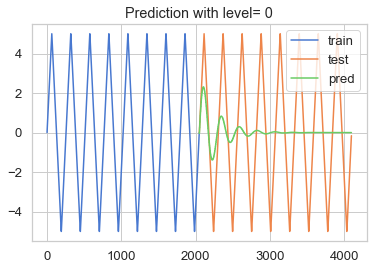

100%|██████████| 2047/2047 [00:00<00:00, 202632.47it/s]


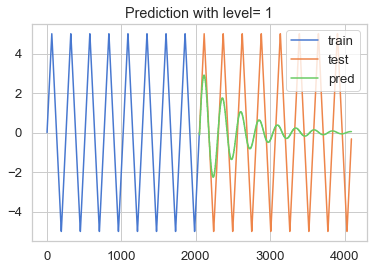

100%|██████████| 2047/2047 [00:00<00:00, 297878.09it/s]


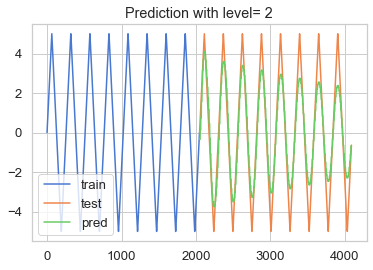

100%|██████████| 2047/2047 [00:00<00:00, 437980.94it/s]


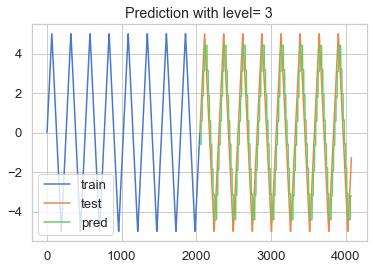

100%|██████████| 2047/2047 [00:00<00:00, 559586.80it/s]


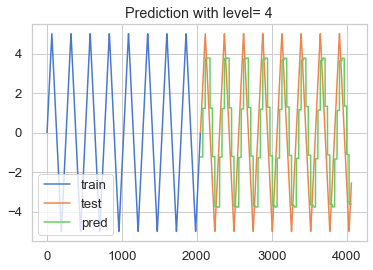

100%|██████████| 2047/2047 [00:00<00:00, 935571.57it/s]


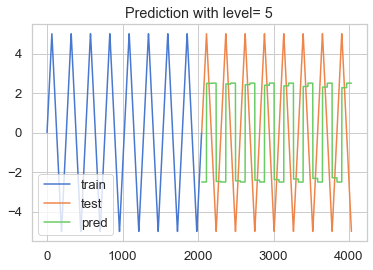

100%|██████████| 2047/2047 [00:00<00:00, 1008426.16it/s]


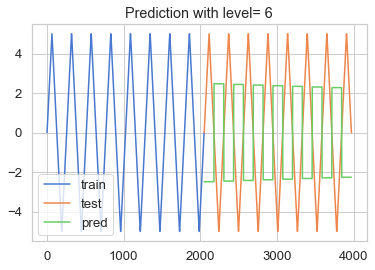

100%|██████████| 2047/2047 [00:00<00:00, 687354.12it/s]


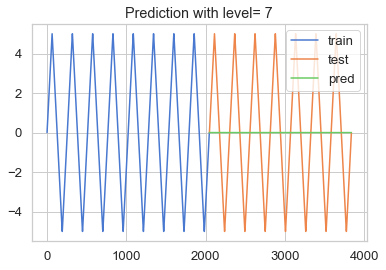

100%|██████████| 2047/2047 [00:00<00:00, 780309.03it/s]


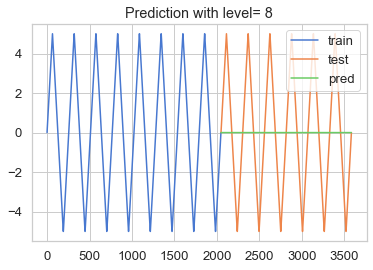

100%|██████████| 2047/2047 [00:00<00:00, 1226534.33it/s]


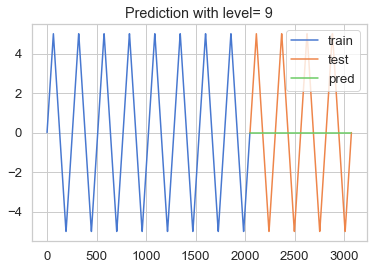

In [213]:
# Prediction
for i in range(awsom.n_eqn):
    pred = awsom.predict(len(data), 2*K, level=i)
    plt.plot()
    plt.title("Prediction with level= {}".format(i))
    plt.plot(data[-2*K:], label="train")
    plt.plot(np.arange(2*K, 2*K+len(pred)), data[np.arange(2*K, 2*K+len(pred))], label="test")
    plt.plot(np.arange(2*K, 2*K+len(pred)), pred, label="pred")
    plt.legend()
    plt.show()

### Mix data

In [149]:
data = mix

# Set AWSOM order
# n = [6, 4, 2]  # i.e., n_0 = 6, n_1 - 4, n_2 = 2
n = [10, 5]
# n = [10]

# Set mother wavelet
wavelet = "haar"
# wavelet = "db6"  # not available

# Get AWSOM instance
awsom = AWSOM(n, wavelet=wavelet, max_depth=10)
print("Input:", data.shape)
print(f"AWSOM({n}) (total order k= {awsom.get_n_params()})")

# Initialization
init_len = 20 * K
init_data = data[:init_len]

print("# Data size in initilization:", init_data.shape)
awsom.init_params(init_data)

awsom.print_status()

Input: (40960,)
AWSOM([10, 5]) (total order k= 15)
# Data size in initilization: (20480,)
depth= 0, # samples= 10229
depth= 1, # samples= 5109
depth= 2, # samples= 2549
depth= 3, # samples= 1269
depth= 4, # samples= 629
depth= 5, # samples= 309
depth= 6, # samples= 149
depth= 7, # samples= 69
depth= 8, # samples= 29

# Wavelet coefficients:
W[1]=
array([-51.06664412, -52.35113896, -52.96166495, -52.87401165,
       -52.09165497, -50.64561927, -48.59324714, -46.01592544,
       -43.01585793, -39.71201236, -36.2354028 ])
W[2]=
array([-29.1296846 , -36.00439943, -45.07708942, -54.92291058,
       -63.99560057, -70.8703154 , -74.46739779, -74.22193466,
       -70.1724754 , -62.95497777, -53.70293228])
W[3]=
array([-102.76928256, -102.10226652,  -82.48959927,  -58.93175697,
        -39.31908972,  -38.65207367,  -57.3332706 ,  -84.08808564,
       -102.76928256, -102.10226652,  -82.48959927])
W[4]=
array([ 132.12811217,   67.87188783,   69.47383995,  -69.47383995,
        -67.87188783, -132.

In [150]:
# verbose_step = np.inf # 2 * K
verbose_step = 5 * K
seqlen = len(data)

# Online update
for t in tqdm.trange(init_len, seqlen):
    awsom.update(t, data[t-2:t])

awsom.print_status()

100%|██████████| 20480/20480 [00:01<00:00, 16258.01it/s]


# Wavelet coefficients:
W[1]=
array([-49.15911709, -51.06664412, -52.35113896, -52.96166495,
       -52.87401165, -52.09165497, -50.64561927, -48.59324714,
       -46.01592544, -43.01585793, -39.71201236])
W[2]=
array([-25.53260221, -29.1296846 , -36.00439943, -45.07708942,
       -54.92291058, -63.99560057, -70.8703154 , -74.46739779,
       -74.22193466, -70.1724754 , -62.95497777])
W[3]=
array([ -84.08808564, -102.76928256, -102.10226652,  -82.48959927,
        -58.93175697,  -39.31908972,  -38.65207367,  -57.3332706 ,
        -84.08808564, -102.76928256, -102.10226652])
W[4]=
array([ 130.52616005,  132.12811217,   67.87188783,   69.47383995,
        -69.47383995,  -67.87188783, -132.12811217, -130.52616005,
        -69.47383995,  -67.87188783, -132.12811217])
W[5]=
array([ -97.11809548, -185.724617  ,  -97.11809548, -185.724617  ,
        185.724617  ,   97.11809548,  185.724617  ,   97.11809548,
        -97.11809548, -185.724617  ,  -97.11809548])
W[6]=
array([ 200.,  200., -200.

100%|██████████| 2047/2047 [00:00<00:00, 65477.02it/s]


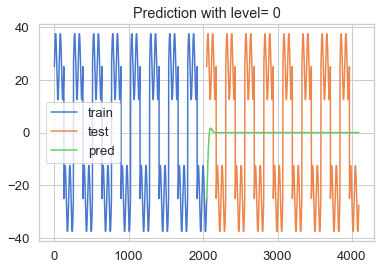

100%|██████████| 2047/2047 [00:00<00:00, 118275.55it/s]


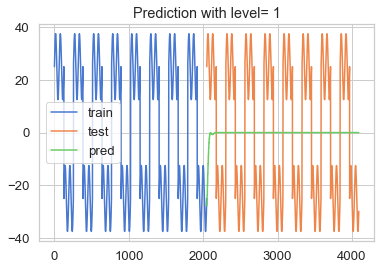

100%|██████████| 2047/2047 [00:00<00:00, 206437.61it/s]


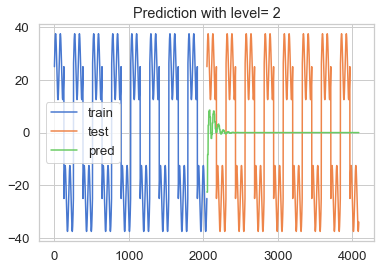

100%|██████████| 2047/2047 [00:00<00:00, 271168.60it/s]


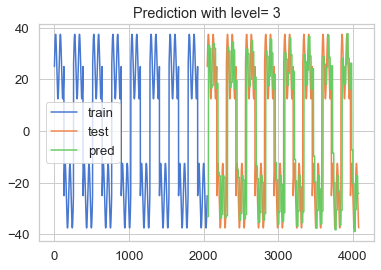

100%|██████████| 2047/2047 [00:00<00:00, 240342.08it/s]


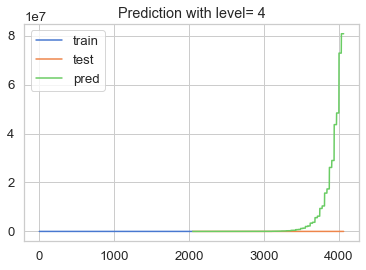

100%|██████████| 2047/2047 [00:00<00:00, 280186.02it/s]


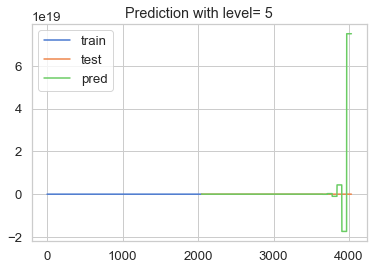

100%|██████████| 2047/2047 [00:00<00:00, 636924.35it/s]


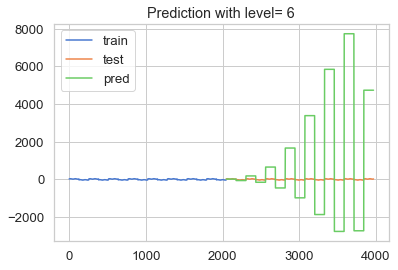

100%|██████████| 2047/2047 [00:00<00:00, 734012.16it/s]


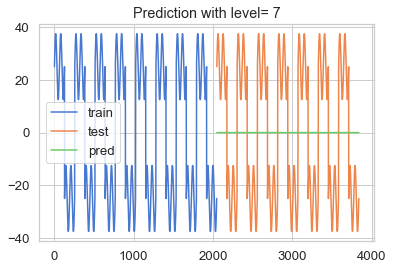

100%|██████████| 2047/2047 [00:00<00:00, 781232.06it/s]


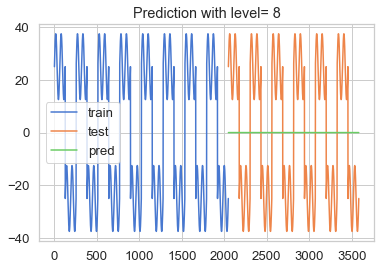

In [151]:
# Prediction
for i in range(awsom.n_eqn):
    pred = awsom.predict(len(data), 2*K, level=i)
    plt.plot()
    plt.title("Prediction with level= {}".format(i))
    plt.plot(data[-2*K:], label="train")
    plt.plot(np.arange(2*K, 2*K+len(pred)), data[np.arange(2*K, 2*K+len(pred))], label="test")
    plt.plot(np.arange(2*K, 2*K+len(pred)), pred, label="pred")
    plt.legend()
    plt.show()

### Impulse data

In [207]:
data = impulse

# Set AWSOM order
# n = [6, 4, 2]  # i.e., n_0 = 6, n_1 - 4, n_2 = 2
# n = [32, 4]
n = [64]

# Set mother wavelet
wavelet = "haar"
# wavelet = "db6"  # not available

# Get AWSOM instance
awsom = AWSOM(n, wavelet=wavelet, max_depth=10)
print("Input:", data.shape)
print(f"AWSOM({n}) (total order k= {awsom.get_n_params()})")

# Initialization
init_len = 100 * K
init_data = data[:init_len]

print("# Data size in initilization:", init_data.shape)
awsom.init_params(init_data)

awsom.print_status()

Input: (131072,)
AWSOM([64]) (total order k= 64)
# Data size in initilization: (102400,)
depth= 0, # samples= 51135
depth= 1, # samples= 25535
depth= 2, # samples= 12735
depth= 3, # samples= 6335
depth= 4, # samples= 3135
depth= 5, # samples= 1535
depth= 6, # samples= 735
depth= 7, # samples= 335
depth= 8, # samples= 135
depth= 9, # samples= 35

# Wavelet coefficients:
W[1]=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
W[2]=
array([  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.

In [208]:
# verbose_step = np.inf # 2 * K
verbose_step = 5 * K
seqlen = len(data)

# Online update
for t in tqdm.trange(init_len, seqlen):
    awsom.update(t, data[t-2:t])

awsom.print_status()

100%|██████████| 28672/28672 [00:01<00:00, 16373.62it/s]


# Wavelet coefficients:
W[1]=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
W[2]=
array([  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
W[3]=
array([ 0.        ,  0.        , 70.71067812,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,

100%|██████████| 2047/2047 [00:00<00:00, 76870.48it/s]


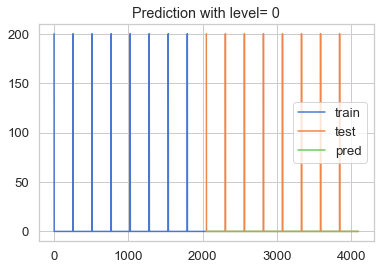

100%|██████████| 2047/2047 [00:00<00:00, 191684.50it/s]


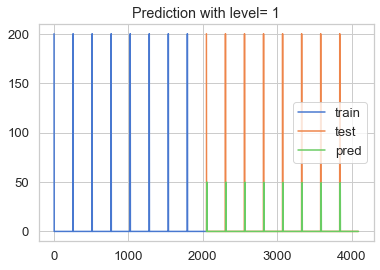

100%|██████████| 2047/2047 [00:00<00:00, 296356.37it/s]


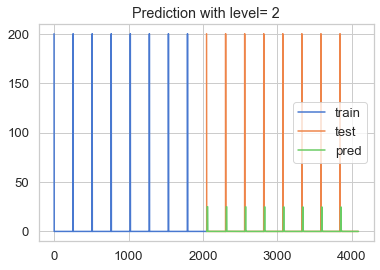

100%|██████████| 2047/2047 [00:00<00:00, 404072.87it/s]


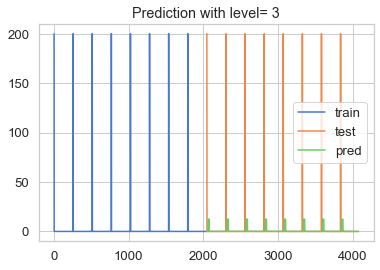

100%|██████████| 2047/2047 [00:00<00:00, 560792.96it/s]


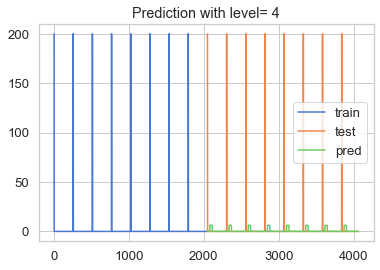

100%|██████████| 2047/2047 [00:00<00:00, 819406.40it/s]


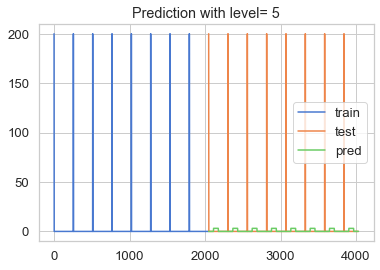

100%|██████████| 2047/2047 [00:00<00:00, 679359.10it/s]


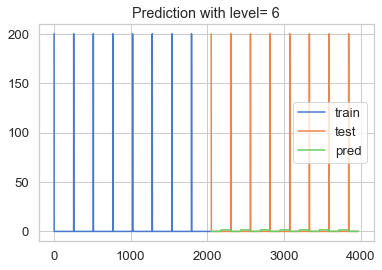

100%|██████████| 2047/2047 [00:00<00:00, 973881.61it/s]


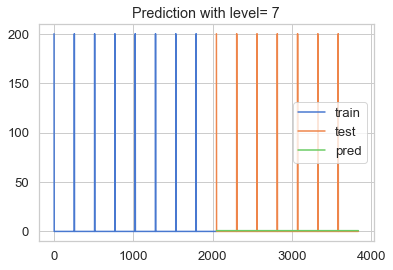

100%|██████████| 2047/2047 [00:00<00:00, 988912.73it/s]


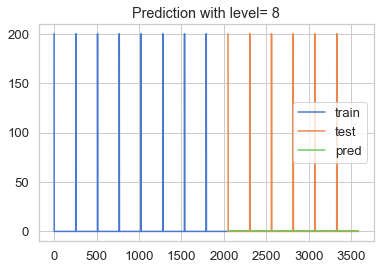

100%|██████████| 2047/2047 [00:00<00:00, 818703.18it/s]


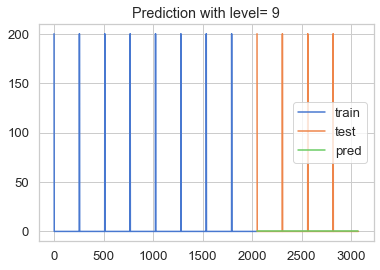

In [209]:
# Prediction
for i in range(awsom.n_eqn):
    pred = awsom.predict(len(data), 2*K, level=i)
    plt.plot()
    plt.title("Prediction with level= {}".format(i))
    plt.plot(data[-2*K:], label="train")
    plt.plot(np.arange(2*K, 2*K+len(pred)), data[np.arange(2*K, 2*K+len(pred))], label="test")
    plt.plot(np.arange(2*K, 2*K+len(pred)), pred, label="pred")
    plt.legend()
    plt.show()